# Does morph predict cell misses?

author: steeve.laquitaine@epfl.ch

Setup environment: 

```bash
pip install requirements_kilosort_silico
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

2023-03-16 13:34:24,169 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-16 13:34:24,204 - root - utils.py - get_config - INFO - Reading experiment config. - done


In [2]:
# get SpikeInterface's MatchingObject
out = match.run()

2023-03-16 13:34:24,703 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-16 13:34:24,745 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-03-16 13:34:24,781 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-16 13:34:24,799 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-03-16 13:34:49,384 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-16 13:34:49,391 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [3]:
cell_matching  = out["cell_matching"]

# add layer feature
cell_matching = feateng.add_property(
    cell_matching, data_conf, properties=["etype"]
)

In [4]:
# count conditions
missed_cells = cell_matching["sorted_cell"].isna()
n_missed_per_layer = cell_matching[missed_cells].drop_duplicates().groupby("etype").size()
n_total_per_layer = cell_matching[["true_cell_match", "etype"]].drop_duplicates().groupby("etype").size()

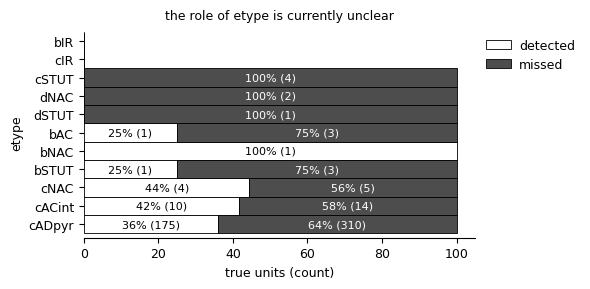

In [20]:
from matplotlib import pyplot as plt

# build histo dataset
df = pd.DataFrame(
    {
        "detected": n_total_per_layer - n_missed_per_layer,
        "missed": n_missed_per_layer,
    },
    index=list(n_missed_per_layer.index),
)
df.sort_values(by="detected",inplace=True)
df_total = df["missed"] + df["detected"]
df_rel = df.div(df_total, 0) * 100

# set figure
fig, axis = plt.subplots(1, 1, figsize=(6, 3))


# set plot legend
colors = ["w", [0.3, 0.3, 0.3],]

# plot
ax = df_rel.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=1,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
ax.invert_yaxis()
ax.set_xlabel("true units (count)", fontsize=9)
ax.set_ylabel("etype", fontsize=9)
ax.legend(
    bbox_to_anchor=(1, 1),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("the role of etype is currently unclear", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(df_rel.cumsum(1)[n], 
                                         df_rel[n], df_rel[n])):
        if n=="missed":
            txt_color="w"
        else:
            txt_color="k"
        if not np.round(pc)==0:
            plt.text(cs - ab / 2, i, "{:.0f}% ({:.0f})".format(np.round(pc), df[n].iloc[i]), 
                    va = 'center', ha = 'center', fontsize = 8, color=txt_color)